<a href="https://colab.research.google.com/github/alakise/Cleveland-Heart-Disease-Dataset-Sandbox/blob/main/Heart_Disease_Risk_Prediction_Model_Final_Best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Definition
Given clinical parameters about a patient, can we predict whether or not they have heart disease?

# Features
Explanation of fields in dataset

## Data Dictionary
1. `age` - age in years
2. `sex` - (1 = male; 0 = female)
3. `cp` - chest pain type
    * 0: Typical angina
    * 1: Atypical angina
    * 2: Non-anginal pain
    * 3: Asymptomatic
4. `trestbps` - resting blood pressure (in mm Hg on admission to the hospital) 
5. `chol` - Serum cholesterole in mg/dl
6. `fbs` - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. `restecg` - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
    * 2: Possible or definite left ventricular hypertrophy
8. `thalach` - maximum heart rate achieved
9. `exang` - exercise induced angina (1 = yes; 0 = no)
10. `oldpeak` - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. `slope` - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. `ca` - number of major vessels (0-3) colored by flourosopy
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. `thal` - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising
14. `target` - have disease or not (1=yes, 0=no) (= the predicted attribute)

# Introduction
First, load the appropriate libraries.

In [ ]:

!pip install -q seaborn

!pip install -q git+https://github.com/tensorflow/docs

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.generic_utils import get_custom_objects

print("Tensorflow sürümü:",tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

     |████████████████████████████████| 1.0MB 6.9MB/s 
Tensorflow sürümü: 2.4.1


In [ ]:
dataset_path = "heart.csv"
column_names = ["Age","Gender","Angina","Rest_BP","Cholesterole","Fasting_BS","ECG","Stress_BPM","SI_Angina","Stress_STDep","Slope", "Colored_Vessels","Thalium","Diagnose"]
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      comment='\t',
                      sep=",", skipinitialspace=True)

df= raw_dataset.copy()
df.head()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df)

,Age,Gender,Angina,Rest_BP,Cholesterole,Fasting_BS,ECG,Stress_BPM,SI_Angina,Stress_STDep,Slope,Colored_Vessels,Thalium,Diagnose
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              303 non-null    int64  
 1   Gender           303 non-null    int64  
 2   Angina           303 non-null    int64  
 3   Rest_BP          303 non-null    int64  
 4   Cholesterole     303 non-null    int64  
 5   Fasting_BS       303 non-null    int64  
 6   ECG              303 non-null    int64  
 7   Stress_BPM       303 non-null    int64  
 8   SI_Angina        303 non-null    int64  
 9   Stress_STDep     303 non-null    float64
 10  Slope            303 non-null    int64  
 11  Colored_Vessels  303 non-null    int64  
 12  Thalium          303 non-null    int64  
 13  Diagnose         303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
df['Gender'] = df['Gender'].map(lambda x: {0: 'Female', 1: 'Male'}.get(x))
df['Angina'] = df['Angina'].map(lambda x: {0: 'Angina', 1: 'Atypical_Angina', 2: 'Non-Anginal'}.get(x))
df['Slope'] = df['Slope'].map(lambda x: {0: 'Upsloping', 1: 'Flatsloping', 2: 'Downsloping'}.get(x))
df.pop("Thalium")
#df['Thalium'] = df['Thalium'].map(lambda x: {6: 'Thalium_Fixed', 7: 'Thalium_Reversable'}.get(x))

df = pd.get_dummies(df, prefix='', prefix_sep='')
df.head()

,Age,Rest_BP,Cholesterole,Fasting_BS,ECG,Stress_BPM,SI_Angina,Stress_STDep,Colored_Vessels,Diagnose,Female,Male,Angina,Atypical_Angina,Non-Anginal,Downsloping,Flatsloping,Upsloping
0,63,145,233,1,0,150,0,2.3,0,1,0,1,0,0,0,0,0,1
1,37,130,250,0,1,187,0,3.5,0,1,0,1,0,0,1,0,0,1
2,41,130,204,0,0,172,0,1.4,0,1,1,0,0,1,0,1,0,0
3,56,120,236,0,1,178,0,0.8,0,1,0,1,0,1,0,1,0,0
4,57,120,354,0,1,163,1,0.6,0,1,1,0,1,0,0,1,0,0


In [ ]:
train_dataset = df.sample(frac=0.80,random_state=0)
test_dataset = df.drop(train_dataset.index)

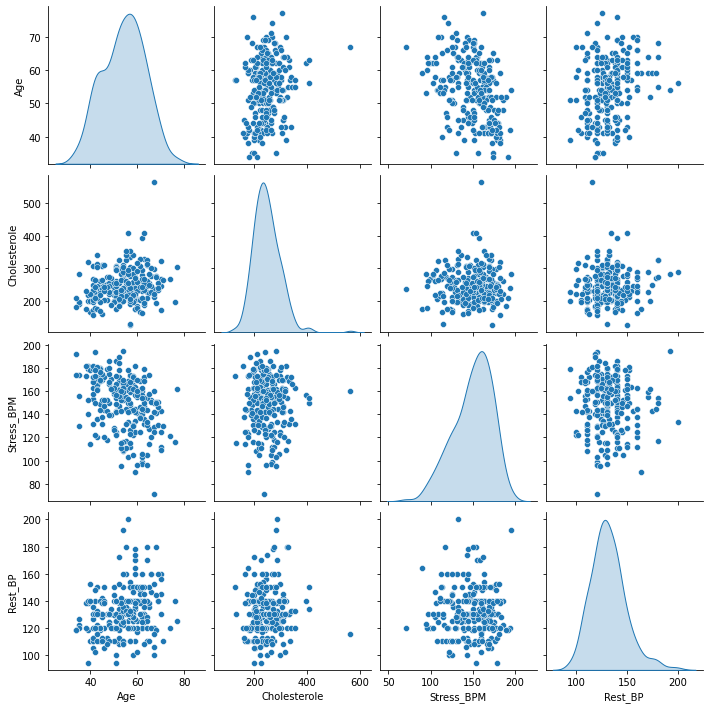

In [ ]:
sns.pairplot(train_dataset[["Age", "Cholesterole", "Stress_BPM", "Rest_BP"]], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("Diagnose")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Age,242.0,54.128099,8.904992,34.0,48.0,54.5,60.75,77.0
Rest_BP,242.0,131.396694,17.352331,94.0,120.0,130.0,140.00,200.0
Cholesterole,242.0,247.181818,51.235037,126.0,212.0,241.5,274.00,564.0
Fasting_BS,242.0,0.144628,0.352454,0.0,0.0,0.0,0.00,1.0
ECG,242.0,0.528926,0.516522,0.0,0.0,1.0,1.00,2.0
Stress_BPM,242.0,149.797521,22.935873,71.0,134.5,153.0,167.75,195.0
SI_Angina,242.0,0.330579,0.471396,0.0,0.0,0.0,1.00,1.0
Stress_STDep,242.0,0.991322,1.162148,0.0,0.0,0.6,1.60,6.2
Colored_Vessels,242.0,0.685950,0.985649,0.0,0.0,0.0,1.00,4.0
Female,242.0,0.314050,0.465098,0.0,0.0,0.0,1.00,1.0


In [ ]:
train_labels = train_dataset.pop('Diagnose')
test_labels = test_dataset.pop('Diagnose')

# Normalize Data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Building Model

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='tanh', input_shape=[len(train_dataset.keys())]),
    layers.Dense(36, activation='tanh'),
    layers.Dense(18, activation='tanh'),
    layers.Dense(1, activation='sigmoid'),
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.6
  )
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[tf.keras.metrics.BinaryAccuracy()])

  return model

model = build_model()
model.summary()
!pip install visualkeras


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1152      
_________________________________________________________________
dense_5 (Dense)              (None, 36)                2340      
_________________________________________________________________
dense_6 (Dense)              (None, 18)                666       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 19        
Total params: 4,177
Trainable params: 4,177
Non-trainable params: 0
_________________________________________________________________


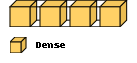

In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True)  # font is optional!

Try short batch

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.39459026],
       [0.39710376],
       [0.43280202],
       [0.42386582],
       [0.46291986],
       [0.47367978],
       [0.5165489 ],
       [0.4616538 ],
       [0.37624985],
       [0.5149999 ]], dtype=float32)

In [ ]:
EPOCHS = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, binary_accuracy:0.6839,  loss:0.2121,  val_binary_accuracy:0.8980,  val_loss:0.1469,  
....................................................................................................
Epoch: 100, binary_accuracy:0.9845,  loss:0.0146,  val_binary_accuracy:0.8980,  val_loss:0.0852,  
....................................................................................................
Epoch: 200, binary_accuracy:0.9896,  loss:0.0104,  val_binary_accuracy:0.8980,  val_loss:0.0876,  
....................................................................................................
Epoch: 300, binary_accuracy:0.9896,  loss:0.0104,  val_binary_accuracy:0.9184,  val_loss:0.0730,  
....................................................................................................
Epoch: 400, binary_accuracy:0.9948,  loss:0.0052,  val_binary_accuracy:0.8980,  val_loss:0.0956,  
....................................................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,binary_accuracy,val_loss,val_binary_accuracy,epoch
495,0.000026,1.0,0.079125,0.918367,495
496,0.000021,1.0,0.079173,0.918367,496
497,0.000016,1.0,0.079069,0.918367,497
498,0.000017,1.0,0.079230,0.918367,498
499,0.000013,1.0,0.079022,0.918367,499


In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'Binary Accuracy')

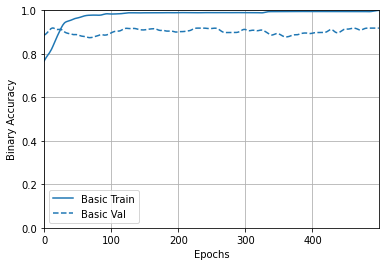

In [ ]:
plotter.plot({'Basic': history}, metric = "binary_accuracy")
plt.ylim([0, 1])
plt.ylabel('Binary Accuracy')

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, binary_accuracy:0.7409,  loss:0.1895,  val_binary_accuracy:0.8367,  val_loss:0.1565,  
........................................................

Text(0, 0.5, 'Binary Accuracy')

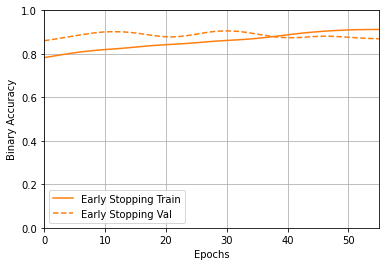

In [ ]:
plotter.plot({'Early Stopping': early_history}, metric = "binary_accuracy")
plt.ylim([0, 1])
plt.ylabel('Binary Accuracy')

In [ ]:
loss, mae = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

2/2 - 0s - loss: 0.0999 - binary_accuracy: 0.8852
Testing set Mean Abs Error:  0.89 MPG


In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

test_predictions

array([0.90843236, 0.9394666 , 0.7456    , 0.7360772 , 0.902405  ,
       0.79960144, 0.9581001 , 0.8678713 , 0.9782887 , 0.93823683,
       0.12003025, 0.95179105, 0.9665448 , 0.81446785, 0.93571067,
       0.71737564, 0.95135105, 0.6771382 , 0.9786563 , 0.95605415,
       0.79144096, 0.8397509 , 0.9740967 , 0.69081104, 0.05075634,
       0.97474086, 0.9731271 , 0.959399  , 0.98091245, 0.7822555 ,
       0.80106914, 0.02162454, 0.3541867 , 0.58139426, 0.02651912,
       0.9456415 , 0.30027914, 0.15898845, 0.10360685, 0.14343968,
       0.02025804, 0.20377547, 0.38586664, 0.23572764, 0.08858007,
       0.02585953, 0.04883248, 0.03317836, 0.03307334, 0.02627662,
       0.1402852 , 0.1623098 , 0.3463252 , 0.2061032 , 0.72277224,
       0.9600028 , 0.5038534 , 0.04662526, 0.14088646, 0.12495783,
       0.02316859], dtype=float32)

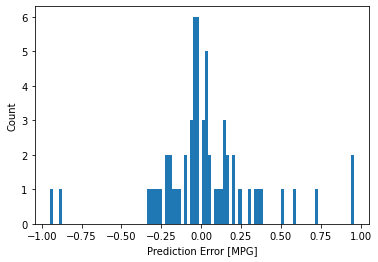

In [ ]:

error = test_predictions - test_labels
plt.hist(error, bins = 100)

plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [ ]:

print(np.mean(error))
print(np.std(error))
print(len(error))
model.save('trained_model.h5')

0.029114062180284592
0.3146762003657088
61


In [ ]:
test_dataset_merged = pd.DataFrame(test_labels, columns=['Diagnose'])
#test_dataset_merged['Diagnose'] = test_labels
test_dataset_merged['Prediction'] = test_predictions

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(test_dataset_merged)

     Diagnose  Prediction
1           1    0.908432
9           1    0.939467
17          1    0.745600
25          1    0.736077
28          1    0.902405
31          1    0.799601
32          1    0.958100
35          1    0.867871
38          1    0.978289
39          1    0.938237
42          1    0.120030
47          1    0.951791
53          1    0.966545
57          1    0.814468
65          1    0.935711
70          1    0.717376
72          1    0.951351
79          1    0.677138
87          1    0.978656
88          1    0.956054
99          1    0.791441
105         1    0.839751
115         1    0.974097
117         1    0.690811
120         1    0.050756
127         1    0.974741
128         1    0.973127
132         1    0.959399
147         1    0.980912
151         1    0.782255
163         1    0.801069
165         0    0.021625
169         0    0.354187
172         0    0.581394
174         0    0.026519
177         0    0.945642
183         0    0.300279
185         